In [1]:
# Import statements
import tensorflow as tf
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
import h5py
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Plot formatting defaults
plt.rc('ytick', direction='out')
plt.rc('grid', color='w', linestyle='solid')
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams.update({'font.size': 22})
plt.rc('xtick', direction='out')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [16]:
# Load in train and test data

mat = scipy.io.loadmat('W8_samples_v2.mat')
W8_cell_data = mat['cell_data']

mat = scipy.io.loadmat('W9_samples_v2.mat')
W9_cell_data = mat['cell_data']

mat = scipy.io.loadmat('W10_samples_v2.mat')
W10_cell_data = mat['cell_data']

mat = scipy.io.loadmat('W5_samples_v2.mat')
W5_cell_data = mat['cell_data']

del mat

X_train, X_train_prev, y_train = shuffle(W8_cell_data[:,2:], W8_cell_data[:,1], W8_cell_data[:,0])

X_test = W9_cell_data[:,2:]
X_test_prev = W9_cell_data[:,1]
y_test = W9_cell_data[:,0]

# Reshape for LSTM: shape = (# samples, # timesteps, # features)
X_train = np.transpose(np.reshape(X_train, (X_train.shape[0], 2, int(X_train.shape[1]/2))), (0, 2, 1))
X_test = np.transpose(np.reshape(X_test, (X_test.shape[0], 2, int(X_test.shape[1]/2))), (0, 2, 1))

# Downsample test by 1/10th
y_test = y_test[0::10]
X_test = X_test[0::10, :, :]
X_test_prev = X_test_prev[0::10]

# Save dimensions for LSTM

n_samp, n_time, n_feat = X_train.shape


#W10 cell data

X_test_W10 = W10_cell_data[:,2:]
X_test_prev_W10 = W10_cell_data[:,1]
y_test_W10 = W10_cell_data[:,0]

# Reshape for CNN: shape = (# samples, # timesteps, # features)
X_test_W10 = np.transpose(np.reshape(X_test_W10, (X_test_W10.shape[0], 2, int(X_test_W10.shape[1]/2))), (0, 2, 1))

# Downsample test by 1/10th
y_test_W10 = y_test_W10[0::10]
X_test_W10 = X_test_W10[0::10, :, :]
X_test_prev_W10 = X_test_prev_W10[0::10]

#W10 cell data

X_test_W5 = W5_cell_data[:,2:]
X_test_prev_W5 = W5_cell_data[:,1]
y_test_W5 = W5_cell_data[:,0]

# Reshape for CNN: shape = (# samples, # timesteps, # features)
X_test_W5 = np.transpose(np.reshape(X_test_W5, (X_test_W5.shape[0], 2, int(X_test_W5.shape[1]/2))), (0, 2, 1))

# Downsample test by 1/10th
y_test_W5 = y_test_W5[0::10]
X_test_W5 = X_test_W5[0::10, :, :]
X_test_prev_W5 = X_test_prev_W5[0::10]

In [52]:
# 1D CNN for current and voltage data
def create_1d_cnn(samp, chan):

    inputShape = (samp, chan, )

    # define the model input
    inputs = layers.Input(shape=inputShape)
 
    x = inputs

    # the first branch operates on the first input
    x = layers.SeparableConv1D(100, 10, data_format='channels_last', padding='same')(x)
    x = layers.MaxPool1D(pool_size=(2))(x)
    x = layers.Conv1D(20, 5, padding='same')(x)
    x = layers.MaxPool1D(pool_size=(2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(200, activation="relu")(x)
    x = layers.Dense(50, activation="relu")(x)

    model = tf.keras.models.Model(inputs, x)

    return model

In [53]:
# Single input linear passthrough of previous capacity
def create_single_mlp(sz):

    inputShape = (sz)

    # define the model input
    inputs = layers.Input(shape=inputShape)

    # the second branch opreates on the second input
    x = layers.Dense(sz)(inputs)

    model = tf.keras.models.Model(inputs, x)

    return model

In [54]:
# create the MLP and CNN models
mlp = create_single_mlp(1)
cnn = create_1d_cnn(1200, 2)
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = layers.concatenate([mlp.output, cnn.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = layers.Dense(20, activation="relu")(combinedInput)
x = layers.Dense(1, activation="linear")(x)
model = tf.keras.models.Model(inputs=[mlp.input, cnn.input], outputs=x)

In [55]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1200, 2)]    0           []                               
                                                                                                  
 separable_conv1d (SeparableCon  (None, 1200, 100)   320         ['input_2[0][0]']                
 v1D)                                                                                             
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 600, 100)     0           ['separable_conv1d[0][0]']       
                                                                                                  
 conv1d (Conv1D)                (None, 600, 20)      10020       ['max_pooling1d[0][0]']    

In [56]:
from datetime import datetime
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [57]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="mean_absolute_error",
    metrics=["mean_squared_error"],
)

history = model.fit(x=[X_train_prev, X_train], y=y_train,
                    epochs=300,
                    verbose=2,
                    batch_size=500,
                    validation_split=0.2,
                    callbacks=[tensorboard_callback])


Epoch 1/300


2022-05-23 22:15:01.579410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-23 22:15:23.293301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


107/107 - 24s - loss: 0.1213 - mean_squared_error: 0.0730 - val_loss: 0.0685 - val_mean_squared_error: 0.0056 - 24s/epoch - 226ms/step
Epoch 2/300
107/107 - 17s - loss: 0.0319 - mean_squared_error: 0.0016 - val_loss: 0.0651 - val_mean_squared_error: 0.0050 - 17s/epoch - 161ms/step
Epoch 3/300
107/107 - 16s - loss: 0.0330 - mean_squared_error: 0.0017 - val_loss: 0.0572 - val_mean_squared_error: 0.0041 - 16s/epoch - 153ms/step
Epoch 4/300
107/107 - 16s - loss: 0.0380 - mean_squared_error: 0.0022 - val_loss: 0.0669 - val_mean_squared_error: 0.0052 - 16s/epoch - 146ms/step
Epoch 5/300
107/107 - 16s - loss: 0.0260 - mean_squared_error: 0.0010 - val_loss: 0.0463 - val_mean_squared_error: 0.0029 - 16s/epoch - 146ms/step
Epoch 6/300
107/107 - 18s - loss: 0.0260 - mean_squared_error: 0.0011 - val_loss: 0.0693 - val_mean_squared_error: 0.0055 - 18s/epoch - 165ms/step
Epoch 7/300
107/107 - 17s - loss: 0.0264 - mean_squared_error: 0.0011 - val_loss: 0.0780 - val_mean_squared_error: 0.0068 - 17s/ep

In [58]:
# Save completed model
model.save("mixmodel_w8_300-500")

INFO:tensorflow:Assets written to: mixmodel_w8_300-500/assets


INFO:tensorflow:Assets written to: mixmodel_w8_300-500/assets


In [ ]:
%tensorboard --logdir logs

In [3]:
# Load model
model = keras.models.load_model("mixmodel_w8_300-500")
# model = keras.models.load_model("mixmodel_w8_200")

2022-05-23 16:56:40.683723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-23 16:56:40.684034: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



  1/223 [..............................] - ETA: 1:01

2022-05-23 23:36:35.429493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


223/223 [==============================] - 2s 7ms/step


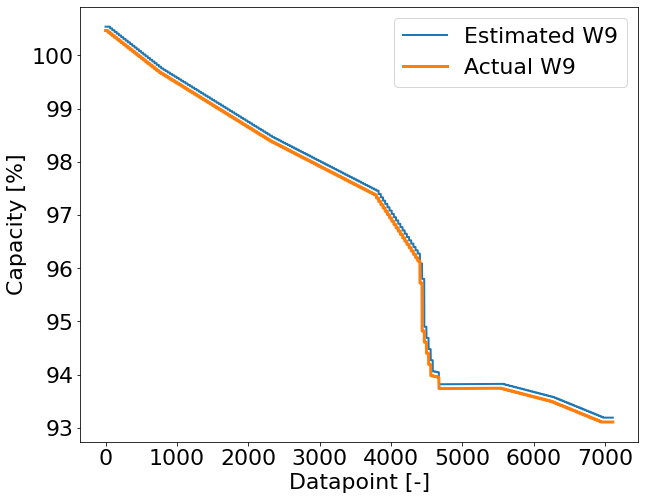

223/223 - 2s - loss: 0.0011 - mean_squared_error: 1.5948e-06 - 2s/epoch - 7ms/step


[0.001073165680281818, 1.5948246527841548e-06]

In [59]:
y_hat = model.predict([X_test_prev, X_test])
y_hat_plot = np.ravel(y_hat)
plt.plot(y_hat_plot*100)
plt.plot(y_test*100, linewidth=3)
plt.legend(['Estimated W9', 'Actual W9'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()

model.evaluate([X_test_prev, X_test], y_test, verbose=2)

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.legend(['Training', 'Validation'])
# plt.xlabel("Epoch [-]")
# plt.ylabel("Loss [%]")
# plt.show()

231/231 [==============================] - 1s 6ms/step


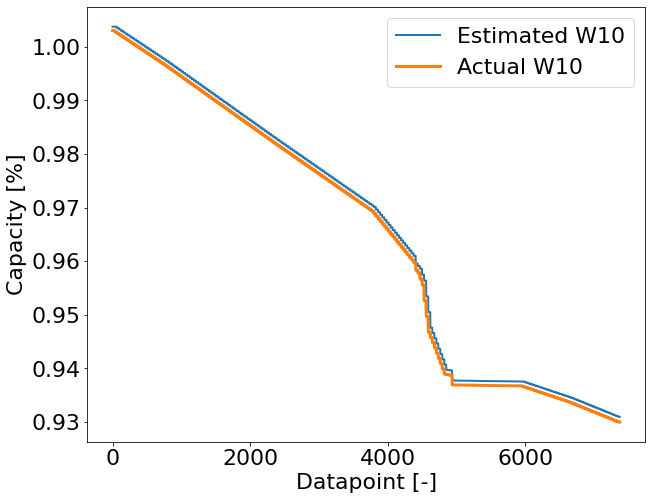

231/231 - 2s - loss: 0.0011 - mean_squared_error: 1.2579e-06 - 2s/epoch - 7ms/step


[0.0010642099659889936, 1.257888243344496e-06]

In [63]:
y_hat_W10 = model.predict([X_test_prev_W10, X_test_W10])
y_hat_plot_W10 = np.ravel(y_hat_W10)
plt.plot(y_hat_plot_W10)
plt.plot(y_test_W10, linewidth=3)
plt.legend(['Estimated W10', 'Actual W10'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
model.evaluate([X_test_prev_W10, X_test_W10], y_test_W10, verbose=2)

252/252 [==============================] - 2s 7ms/step


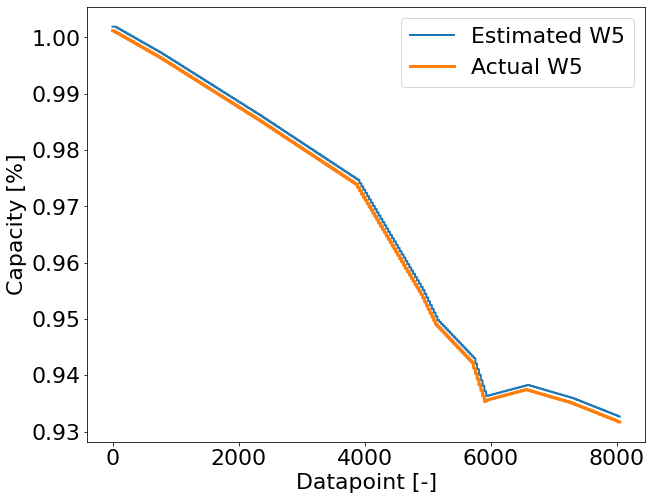

252/252 - 2s - loss: 0.0010 - mean_squared_error: 1.1149e-06 - 2s/epoch - 7ms/step


[0.0010337565327063203, 1.1149027159262914e-06]

In [64]:
y_hat_W5 = model.predict([X_test_prev_W5, X_test_W5])
y_hat_plot_W5 = np.ravel(y_hat_W5)
plt.plot(y_hat_plot_W5)
plt.plot(y_test_W5, linewidth=3)
plt.legend(['Estimated W5', 'Actual W5'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
model.evaluate([X_test_prev_W5, X_test_W5], y_test_W5, verbose=2)

In [23]:
X_test_prev_W10.shape

(7372,)

In [24]:
X_test_W10.shape

(7372, 1200, 2)

In [28]:
# TODO: Reconstruct test data into a for loop
# Each row of data corresponds to a different cycle
# Initialize the capacity as a global variable; set to nominal capacity
# Within for loop:
# Predict one time step ahead using capacity and row of data
# Set the capacity to the predicted capacity
# Store new capacity
# return to beginning of loop...
# Plot capacity vs. cycle number against known data

mat = scipy.io.loadmat('W8_test_examps.mat')
W8_test_exs = mat['test_exs']
# print(W8_test_exs.shape)


In [60]:
y_cycles_true = W8_test_exs[:,0,0]

test_cap = y_cycles_true[0]
test_cap = np.reshape(test_cap, (1,))
# test_cap = np.asarray(test_cap).astype('float32')
test_cv = W8_test_exs[1, 1:, 0]
test_cv = np.reshape(test_cv, (1, 1200, 2))
# test_cv = np.asarray(test_cv).astype('float32')
# print(test_cv.shape)
# print(test_cap.shape)
y_hat_samp = model.predict([test_cap, test_cv])      
print(y_hat_samp)  

1/1 [==============================] - 0s 87ms/step
[[1.0059042]]


In [61]:
ncycles, nps, nexamps = W8_test_exs.shape

# Extract ground truth cycle capacities
y_cycles_true = W8_test_exs[:,0,0]

# Preallocate capacity results array
y_cycles_pred_all = np.zeros((ncycles, nexamps))

for i in range(3):
    # Initialize capacity to initial capacity
    cyc_cap = y_cycles_true[0]
    cyc_cap = np.reshape(cyc_cap, (1,))
    y_cycles_pred_all[0,i] = cyc_cap
    for j in range(1, ncycles):  
        samp_cv = W8_test_exs[j, 1:, i]
        samp_cv = np.reshape(samp_cv, (1, 1200, 2))
        y_hat_samp = model.predict([cyc_cap, samp_cv], verbose=0)
        cyc_cap = y_hat_samp
        y_cycles_pred_all[j,i] = cyc_cap
    print("Sample {} Complete".format(i))
        

2022-05-23 23:36:59.505195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Sample 0 Complete
Sample 1 Complete
Sample 2 Complete


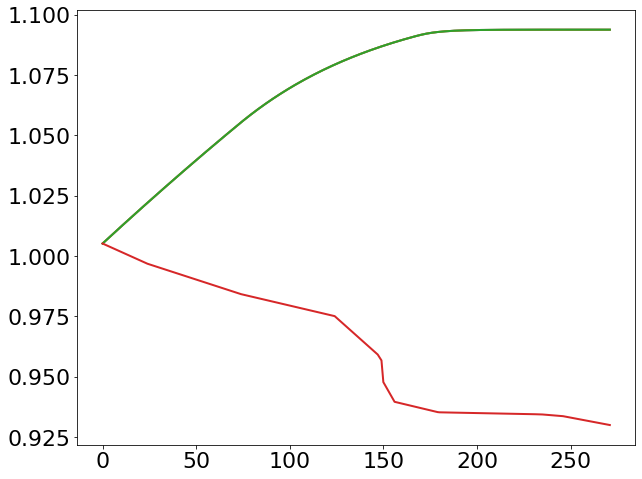

In [62]:
for i in range(3):
    plt.plot(y_cycles_pred_all[:,i])
plt.plot(y_cycles_true)
plt.show()